In [1]:
import numpy as np
import joblib
import ijson
from scipy.stats import skew, kurtosis, mode, entropy, zscore
from sklearn.metrics import silhouette_samples
from sklearn.decomposition import IncrementalPCA
import json

In [2]:
batch_size = 1200  # Adjust based on your memory constraints
n_components = 200  # Number of PCA components
json_file_path = "extracted_features.json"

In [3]:
model_path = "kmeans_models/kmeans_19_clusters.pkl"
kmeans_model = joblib.load(model_path)

In [4]:
ipca = IncrementalPCA(n_components=n_components)

In [5]:
reduced_data_list = []

In [6]:
print("Fitting Incremental PCA in batches...")
with open(json_file_path, "r") as f:
    batch_data = []
    for idx, (img_name, features) in enumerate(ijson.kvitems(f, '')):
        features_np = np.array(features).flatten().reshape(1, -1)
        batch_data.append(features_np)

        if len(batch_data) >= batch_size:
            batch_array = np.vstack(batch_data)
            # Fit the batch with IncrementalPCA
            ipca.partial_fit(batch_array)
            # Transform the batch with IncrementalPCA
            reduced_batch = ipca.transform(batch_array)
            reduced_data_list.append(reduced_batch)
            # Clear the batch data
            batch_data = []

    # Process the remaining data
    if batch_data:
        batch_array = np.vstack(batch_data)
        # Transform the remaining data
        reduced_batch = ipca.transform(batch_array)
        reduced_data_list.append(reduced_batch)

print("Incremental PCA fitting and transformation completed.")


Fitting Incremental PCA in batches...
Incremental PCA fitting and transformation completed.


In [7]:
reduced_data = np.vstack(reduced_data_list)
print("Predicting cluster labels...")
cluster_labels = kmeans_model.predict(reduced_data)

print("Cluster labeling completed.")

Predicting cluster labels...
Cluster labeling completed.


In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

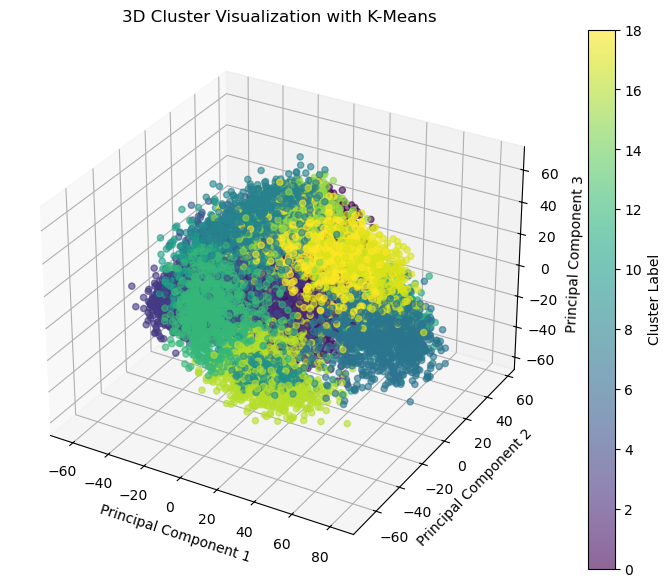

In [12]:
cluster_centers = kmeans_model.cluster_centers_

# Assuming `reduced_data` is your 3D PCA-transformed data
# and `cluster_labels` are the labels from the KMeans model
# (You should have `reduced_data` and `cluster_labels` already computed)

# Create a 3D scatter plot for visualizing the clusters
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the data points colored by their cluster labels
sc = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], 
                c=cluster_labels, cmap='viridis', marker='o', alpha=0.6)

# Scatter plot for the cluster centers marked as red 'X'
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], 
           s=300, c='red', marker='X')

# Set plot titles and labels
ax.set_title('3D Cluster Visualization with K-Means')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add a colorbar to indicate the cluster labels
plt.colorbar(sc, ax=ax, label='Cluster Label')

# Display the plot
plt.show()

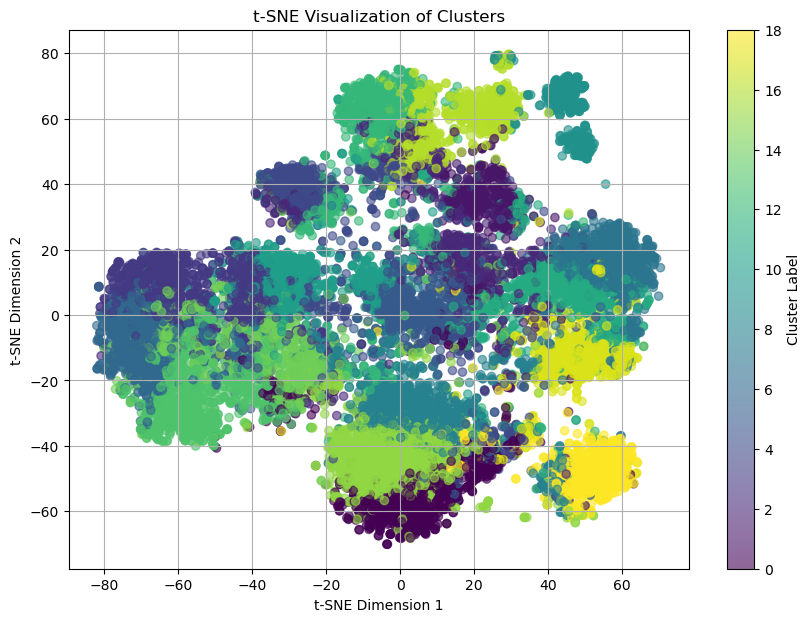

In [13]:
from sklearn.manifold import TSNE

# Assuming `reduced_data` is your PCA-transformed data
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(reduced_data)

plt.figure(figsize=(10, 7))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='viridis', marker='o', alpha=0.6)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()

In [14]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from langchain import LLMChain
from langchain.prompts import PromptTemplate

/opt/anaconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
tokenizer = AutoTokenizer.from_pretrained("Laim/Llama-3.1-MedPalm2-imitate-8B-Instruct")
model = AutoModelForCausalLM.from_pretrained("Laim/Llama-3.1-MedPalm2-imitate-8B-Instruct")

Loading checkpoint shards: 100%|██████████| 4/4 [00:54<00:00, 13.65s/it]


In [16]:
def generate_description_from_llm(cluster_stats):
    prompt_template = f"""
    You are an expert medical image analyst. You are analyzing clusters of Chest X-ray features extracted from the VinBigData dataset. Each cluster contains a group of images with certain shared statistical properties, and your task is to interpret these statistics and provide potential medical insights.

    - **Mean of feature values**: {cluster_stats['mean']}
    - **Standard deviation of feature values**: {cluster_stats['std']}
    - **Variance**: {cluster_stats['variance']}
    - **Median**: {cluster_stats['median']}
    - **Minimum value**: {cluster_stats['min']}
    - **Maximum value**: {cluster_stats['max']}
    - **Range**: {cluster_stats['range']}
    - **Skewness**: {cluster_stats['skew']}
    - **Kurtosis**: {cluster_stats['kurtosis']}
    - **Interquartile Range (IQR)**: {cluster_stats['iqr']}
    - **Mode**: {cluster_stats['mode']}
    - **Count of samples in this cluster**: {cluster_stats['count']}
    - **Entropy**: {cluster_stats['entropy']}
    - **Coefficient of Variation (CV)**: {cluster_stats['cv']}
    - **Silhouette Score**: {cluster_stats['silhouette']}
    
    ### Instructions:
    1. **Describe the cluster**: Based on these statistics, provide a summary of what these values suggest about this group of images. Consider both the central tendencies and the spread of values.
    2. **Identify any abnormalities**: Are there any signs of medical abnormalities, such as high variance or skewness, that could indicate a particular condition or issue in the chest X-ray images?
    3. **Clinical Relevance**: Explain how these patterns might relate to medical findings in Chest X-ray data, particularly in terms of lung diseases or abnormalities.
    4. **Cluster Similarity**: Based on the silhouette score, discuss how distinct this cluster might be from other clusters. Does this score suggest well-defined patterns, or does it indicate overlapping characteristics with other clusters?

    Please provide your description in clear, medically relevant terms.
    """
    inputs = tokenizer(prompt_template, return_tensors="pt")
    outputs = model.generate(
        **inputs,
        max_new_tokens=150,      
        temperature=0.2,         
        top_p=0.9,             
        repetition_penalty=1.5  
    )
    report = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    return report

In [17]:
output_file = "cluster_descriptions.json"

In [18]:
# Initialize JSON for descriptions
cluster_descriptions = {}

# Calculate cluster statistics and pass them to MedPaLM2 LLM for generating descriptions
with open(output_file, "w") as json_file:
    for cluster in range(kmeans_model.n_clusters):
        # Get all data points assigned to this cluster
        cluster_data = reduced_data[cluster_labels == cluster]
        
        # Calculate statistics for this cluster
        cluster_mean = np.mean(cluster_data, axis=0)
        cluster_std = np.std(cluster_data, axis=0)
        cluster_variance = np.var(cluster_data, axis=0)
        cluster_median = np.median(cluster_data, axis=0)
        cluster_min = np.min(cluster_data, axis=0)
        cluster_max = np.max(cluster_data, axis=0)
        cluster_range = cluster_max - cluster_min
        cluster_skew = skew(cluster_data, axis=0)
        cluster_kurtosis = kurtosis(cluster_data, axis=0)
        cluster_iqr = np.percentile(cluster_data, 75, axis=0) - np.percentile(cluster_data, 25, axis=0)
        cluster_mode = mode(cluster_data, axis=0).mode
        cluster_count = len(cluster_data)
        cluster_entropy = entropy(np.histogram(cluster_data, bins=10, density=True)[0], base=2)
        cluster_cv = (np.std(cluster_data, axis=0) / np.mean(cluster_data, axis=0)) * 100
        cluster_silhouette = silhouette_samples(reduced_data, cluster_labels)[cluster_labels == cluster]
        
        # Prepare cluster stats to be passed to the LLM
        cluster_stats = {
            'mean': cluster_mean.tolist(),
            'std': cluster_std.tolist(),
            'variance': cluster_variance.tolist(),
            'median': cluster_median.tolist(),
            'min': cluster_min.tolist(),
            'max': cluster_max.tolist(),
            'range': cluster_range.tolist(),
            'skew': cluster_skew.tolist(),
            'kurtosis': cluster_kurtosis.tolist(),
            'iqr': cluster_iqr.tolist(),
            'mode': cluster_mode.tolist(),
            'count': cluster_count,
            'entropy': cluster_entropy,
            'cv': cluster_cv.tolist(),
            'silhouette': cluster_silhouette.tolist()
        }
        
        # Pass cluster stats to MedPaLM2 LLM and get the description
        description = generate_description_from_llm(cluster_stats)
        
        # Save the description for this cluster
        cluster_descriptions[cluster] = {
            'description': description
        }
        
        # Write each cluster's description to JSON file incrementally
        json_file.write(json.dumps({cluster: cluster_descriptions[cluster]}, indent=4))
        json_file.write(",\n") 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


: 

: 